In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import orekit

In [2]:
from orekit.pyhelpers import setup_orekit_curdir, absolutedate_to_datetime, datetime_to_absolutedate
from org.orekit.utils import ExtendedPVCoordinatesProvider
from org.orekit.orbits import OrbitType, KeplerianOrbit, EquinoctialOrbit, PositionAngle
from org.orekit.propagation.semianalytical.dsst import DSSTPropagator
from org.orekit.propagation import PropagationType
from org.orekit.propagation.semianalytical.dsst.forces import DSSTZonal, DSSTTesseral
from org.orekit.propagation import SpacecraftState
from org.orekit.frames import FramesFactory
from org.hipparchus.ode.nonstiff import DormandPrince853Integrator
from org.orekit.forces.gravity.potential import GravityFieldFactory
from orekit import JArray_double
from org.orekit.bodies import CelestialBodyFactory, CelestialBody,OneAxisEllipsoid
from org.orekit.utils import IERSConventions
from org.orekit.utils import Constants

In [3]:
vm = orekit.initVM()
setup_orekit_curdir("../../../orekit-data.zip")

In [4]:
def frozen(body_shape, celestial_body, **kwargs):
    """Computes keplerian elements of frozen orbit.
    All units are SI.
    """
    a = kwargs["a"] if "a" in kwargs else None
    i = kwargs["i"] if "i" in kwargs else np.deg2rad(63.44)
    w = np.deg2rad(90)
    raan = kwargs["raan"] if "raan" in kwargs else None

    # constants
    R = body_shape.getEquatorialRadius()
    J2 = 0.108265e-2
    J3 = -0.254503e-5
    mu = celestial_body.getGM()

    time = kwargs["time"] if "time" in kwargs else datetime.datetime.utcnow()

    if a is not None:
        e = -0.5 * J3 / J2 * (R / a) * np.sin(i) * np.sin(w)
    else:
        raise ValueError(
            "Insufficient arguments to compute frozen orbit. Provide a.")

    return w, e


In [5]:
# simulation times
t_start = datetime.datetime.utcnow()
duration = 200 * 24 * 60 * 60
t_end = t_start + datetime.timedelta(seconds=duration)
step_size = 24*60*60
# orekit times
t_start_ok = datetime_to_absolutedate(t_start)
t_end_ok = datetime_to_absolutedate(t_end)

In [6]:
time_vec_orekit = [t_start_ok.shiftedBy(float(dt)) for dt in np.arange(0, duration, step_size)]


In [7]:
inertial_frame = FramesFactory.getEME2000()

In [8]:
earth_frame = FramesFactory.getITRF(IERSConventions.IERS_2010, True)

In [9]:
# earth position velocity object
earth = CelestialBodyFactory.getEarth()
earth_pv = ExtendedPVCoordinatesProvider.cast_(earth)

# earth shape: an ellipsoid
earth_shape = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS,
                               Constants.WGS84_EARTH_FLATTENING, earth_frame)


In [10]:
sun =  CelestialBodyFactory.getSun()

In [11]:
a = earth_shape.getEquatorialRadius() + 567e3
i = np.deg2rad(97.7)
w, e = frozen(earth_shape, earth, a=a, i=i)
raan = 0

In [12]:
e

0.001069680671543673

In [13]:
e_all = [1.05*e, 0.99*e, 1.1*e, 1.01*e, 1.03*e]

In [14]:
lines = []
ecc_centers  = []

eccentricity: 0.0012334722880404869
eccentricity: 0.0012374788534426386
eccentricity: 0.0012301357382918947
eccentricity: 0.001236143005393583
eccentricity: 0.0012348074832127668


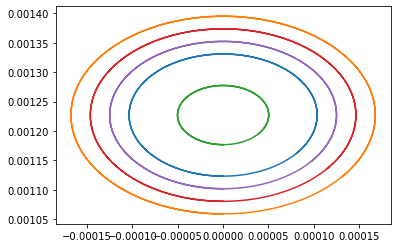

In [15]:
for e in e_all:
    initial_state = SpacecraftState(
    EquinoctialOrbit(float(a), float(e * np.cos(w + 0)),
                        float(e * np.sin(w + 0)),
                        float(np.tan(i / 2) * np.cos(0)),
                        float(np.tan(i / 2) * np.sin(0)), float(0 + w + 0),
                        PositionAngle.MEAN, inertial_frame,
                        t_start_ok, earth.getGM()),
    float(100.0))
    min_step = float(86400.0)
    max_step = float(86400.0)
    position_tolerance = float(1.0)
    orbit_type = OrbitType.EQUINOCTIAL
    tolerances = DSSTPropagator.tolerances(position_tolerance, float(1e-3),
                                            initial_state.getOrbit())
    integrator = DormandPrince853Integrator(min_step, max_step,
                                            JArray_double.cast_(tolerances[0]),
                                            JArray_double.cast_(tolerances[1]))
    propagator = DSSTPropagator(integrator, PropagationType.MEAN)
    zonal_force = DSSTZonal(GravityFieldFactory.getUnnormalizedProvider(51, 51))
    tesseral_force = DSSTTesseral(earth_frame, float(2*np.pi/86400), GravityFieldFactory.getUnnormalizedProvider(21, 21))
    propagator.addForceModel(zonal_force)
    # propagator.addForceModel(tesseral_force)
    propagator.setInitialState(initial_state, PropagationType.MEAN)
    sc_data = [propagator.propagate(t) for t in time_vec_orekit]
    sma_propagated = [s.getA() / 1e3 for s in sc_data]
    i_propagated = [s.getI() for s in sc_data]
    e_propagated = []
    w_propagated = []
    raan_propagated = []
    mean_anomaly_propagated = []
    for state in sc_data:
        keplerian = KeplerianOrbit.cast_(
            OrbitType.KEPLERIAN.convertType(state.getOrbit()))
        e_propagated.append(keplerian.getE())
        w_propagated.append(keplerian.getPerigeeArgument())
        raan_propagated.append(keplerian.getRightAscensionOfAscendingNode())
        mean_anomaly_propagated.append(keplerian.getAnomaly(PositionAngle.MEAN))

    ex = np.multiply(np.array(e_propagated),
                        np.cos(np.array(w_propagated)))
    ey = np.multiply(np.array(e_propagated),
                        np.sin(np.array(w_propagated)))
    center = np.linalg.norm([np.mean(ex), np.mean(ey)])
    print(f"eccentricity: {center}")
    ecc_centers.append(center)
    ax = plt.plot(ex, ey)
    lines.append(ax[0])
# plt.legend(lines, e_all)


In [16]:
average_center = np.mean(ecc_centers)
average_center

0.0012344074736762739

In [17]:
w, e_j2j3 = frozen(earth_shape, earth, a=a, i=i)
e_num = average_center

In [18]:
initial_state_j2j3 = SpacecraftState(
    EquinoctialOrbit(float(a), float(e_j2j3 * np.cos(w + 0)),
                        float(e_j2j3 * np.sin(w + 0)),
                        float(np.tan(i / 2) * np.cos(0)),
                        float(np.tan(i / 2) * np.sin(0)), float(0 + w + 0),
                        PositionAngle.MEAN, inertial_frame,
                        t_start_ok, earth.getGM()),
    float(100.0))

In [19]:
min_step = float(86400.0)
max_step = float(86400.0)
position_tolerance = float(1.0)
orbit_type = OrbitType.EQUINOCTIAL
tolerances = DSSTPropagator.tolerances(position_tolerance, float(1e-3),
                                        initial_state_j2j3.getOrbit())
integrator = DormandPrince853Integrator(min_step, max_step,
                                        JArray_double.cast_(tolerances[0]),
                                        JArray_double.cast_(tolerances[1]))


In [20]:
propagator = DSSTPropagator(integrator, PropagationType.MEAN)
zonal_force = DSSTZonal(GravityFieldFactory.getUnnormalizedProvider(51, 51))
tesseral_force = DSSTTesseral(earth_frame, float(2*np.pi/86400), GravityFieldFactory.getUnnormalizedProvider(50, 50))
propagator.addForceModel(zonal_force)
propagator.setInitialState(initial_state_j2j3, PropagationType.MEAN)

In [21]:
sc_data = [propagator.propagate(t) for t in time_vec_orekit]

In [22]:
sma_propagated_j2j3 = [s.getA() / 1e3 for s in sc_data]
i_propagated_j2j3 = [s.getI() for s in sc_data]
e_propagated_j2j3 = []
w_propagated_j2j3 = []
raan_propagated_j2j3 = []
mean_anomaly_propagated_j2j3 = []
for state in sc_data:
    keplerian = KeplerianOrbit.cast_(
        OrbitType.KEPLERIAN.convertType(state.getOrbit()))
    e_propagated_j2j3.append(keplerian.getE())
    w_propagated_j2j3.append(keplerian.getPerigeeArgument())
    raan_propagated_j2j3.append(keplerian.getRightAscensionOfAscendingNode())
    mean_anomaly_propagated_j2j3.append(keplerian.getAnomaly(PositionAngle.MEAN))

In [23]:
ex_j2j3 = np.multiply(np.array(e_propagated_j2j3),
                    np.cos(np.array(w_propagated_j2j3)))
ey_j2j3 = np.multiply(np.array(e_propagated_j2j3),
                    np.sin(np.array(w_propagated_j2j3)))


In [24]:
initial_state_num = SpacecraftState(
    EquinoctialOrbit(float(a), float(e_num * np.cos(w + 0)),
                        float(e_num * np.sin(w + 0)),
                        float(np.tan(i / 2) * np.cos(0)),
                        float(np.tan(i / 2) * np.sin(0)), float(0 + w + 0),
                        PositionAngle.MEAN, inertial_frame,
                        t_start_ok, earth.getGM()),
    float(100.0))

In [25]:
propagator = DSSTPropagator(integrator, PropagationType.MEAN)
zonal_force = DSSTZonal(GravityFieldFactory.getUnnormalizedProvider(51, 51))
tesseral_force = DSSTTesseral(earth_frame, float(2*np.pi/86400), GravityFieldFactory.getUnnormalizedProvider(21, 21))
propagator.addForceModel(zonal_force)
propagator.setInitialState(initial_state_num, PropagationType.MEAN)

In [26]:
sc_data = [propagator.propagate(t) for t in time_vec_orekit]

In [27]:
sma_propagated_num = [s.getA() / 1e3 for s in sc_data]
i_propagated_num = [s.getI() for s in sc_data]
e_propagated_num = []
w_propagated_num = []
raan_propagated_num = []
mean_anomaly_propagated_num = []
for state in sc_data:
    keplerian = KeplerianOrbit.cast_(
        OrbitType.KEPLERIAN.convertType(state.getOrbit()))
    e_propagated_num.append(keplerian.getE())
    w_propagated_num.append(keplerian.getPerigeeArgument())
    raan_propagated_num.append(keplerian.getRightAscensionOfAscendingNode())
    mean_anomaly_propagated_num.append(keplerian.getAnomaly(PositionAngle.MEAN))

In [28]:
ex_num = np.multiply(np.array(e_propagated),
                    np.cos(np.array(w_propagated)))
ey_num = np.multiply(np.array(e_propagated),
                    np.sin(np.array(w_propagated)))


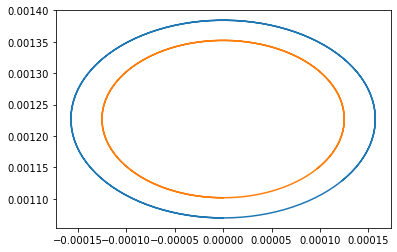

In [29]:
plt.plot(ex_j2j3, ey_j2j3)
plt.plot(ex_num, ey_num)

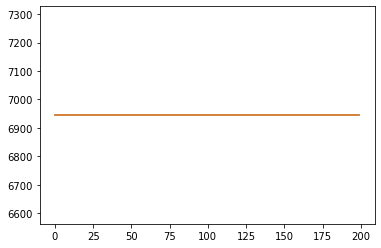

In [30]:
plt.plot(sma_propagated_j2j3)
plt.plot(sma_propagated_num)

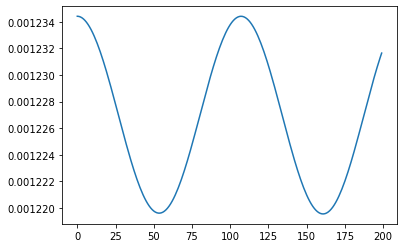

In [31]:
plt.plot(e_propagated_num)

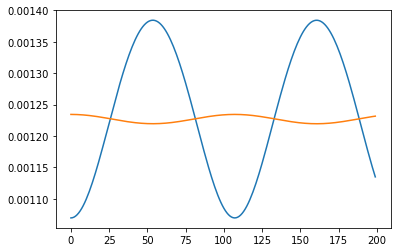

In [32]:
plt.plot(e_propagated_j2j3)
plt.plot(e_propagated_num)

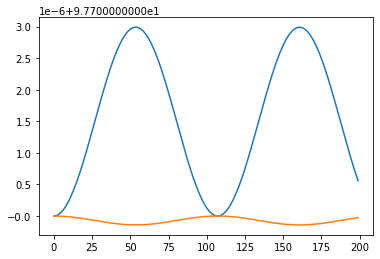

In [33]:
plt.plot(np.rad2deg(np.array(i_propagated_j2j3)))
plt.plot(np.rad2deg(np.array(i_propagated_num)))

Text(0.5, 0, 'steps')

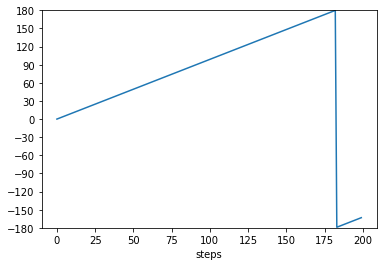

In [34]:
f_raan = plt.figure("raan")
ax_raan = f_raan.add_subplot(111)
ax_raan.plot(np.rad2deg(np.array(raan_propagated_j2j3)))
ax_raan.plot(np.rad2deg(raan))
ax_raan.set_ylim(-180, 180)
ax_raan.set_yticks(np.arange(-180, 210, 30))
ax_raan.set_xlabel("steps")

Text(0.5, 0, 'steps')

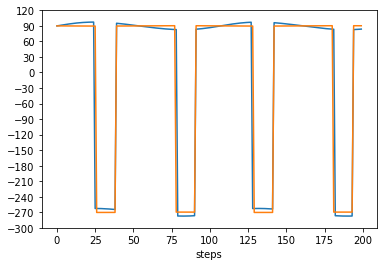

In [35]:
f = plt.figure("perigee")
ax_perigee = f.add_subplot(111)
ax_perigee.plot(np.rad2deg(np.array(w_propagated_j2j3)))
ax_perigee.plot(np.rad2deg(np.array(w_propagated_num)))
ax_perigee.set_ylim(-270, 90)
ax_perigee.set_yticks(np.arange(-300, 150, 30))
ax_perigee.set_xlabel("steps")

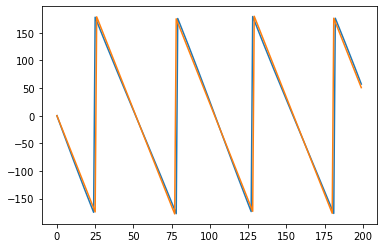

In [36]:
f = plt.figure("mean_anomaly")
ax_ma = f.add_subplot(111)
ax_ma.plot(np.rad2deg(np.array(mean_anomaly_propagated_j2j3)))
ax_ma.plot(np.rad2deg(np.array(mean_anomaly_propagated_num)))


Text(0.5, 0, 'steps')

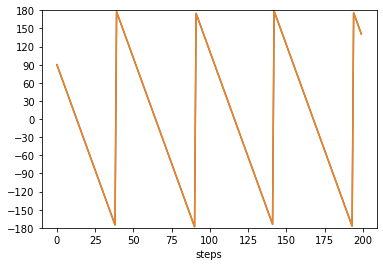

In [37]:
f = plt.figure("arg_latitude")
ax_arg_lat = f.add_subplot(111)
ax_arg_lat.plot(np.rad2deg(np.array(mean_anomaly_propagated_j2j3) + np.array(w_propagated_j2j3)))
ax_arg_lat.plot(np.rad2deg(np.array(mean_anomaly_propagated_num) + np.array(w_propagated_num)))
ax_arg_lat.set_ylim(-180, 180)
ax_arg_lat.set_yticks(np.arange(-180, 210, 30))
ax_arg_lat.set_xlabel("steps")